In [ ]:
import pandas as pd

train = pd.read_csv("./dataset/train.csv")
test = pd.read_csv("./dataset/test.csv")
validation = pd.read_csv("./dataset/validation.csv")

In [ ]:
import re
import nltk
import string
from bs4 import BeautifulSoup
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
more_stopwords = {'u', "im", "day"}
stop_words  = stop_words.union(more_stopwords)    
    
# Basic text cleaning 
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def clean_text(text):
    text = str(text).lower()                                         # Convert to lowercase
    text = re.sub('\[.*?\]', '', text)                               # Remove text in square bracket   
    text = re.sub('https?://\S+|www\.\S+', '', text)                 # Remove links
    text = strip_html(text)                                          # Remove HTML tags
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub('\n', '', text)                                    # Remove line breaks
    text = re.sub('\w*\d\w*', '', text)                              # Remove characters contain digits
    return text

def preprocess_text(text):
    text = clean_text(text)
    # Tokenization
    tokens = nltk.word_tokenize(text) 
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

In [ ]:
# Apply preprocessing
train['tokens'] = train['text'].apply(preprocess_text)
test['tokens'] = test['text'].apply(preprocess_text)
validation['tokens'] = validation['text'].apply(preprocess_text)

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
from transformers import XLNetTokenizer, TFXLNetForSequenceClassification

def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42) 

# Load XLNet model and tokenizer
model_name = "xlnet-base-cased"
tokenizer = XLNetTokenizer.from_pretrained(model_name)
model = TFXLNetForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=3
)

In [ ]:
# Tokenization
max_length = 23
train_encodings = tokenizer(train['text'].tolist(), truncation=True, padding=True, max_length=max_length)
test_encodings = tokenizer(test['text'].tolist(), truncation=True, padding=True, max_length=max_length)
validation_encodings = tokenizer(validation['text'].tolist(), truncation=True, padding=True, max_length=max_length)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Convert sentiment labels to numerical values
le= LabelEncoder()
train['label']= le.fit_transform(train['sentiment'])
test['label'] = le.transform(test['sentiment'])
validation['label'] = le.transform(validation['sentiment'])

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train['label']
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test['label']
))
validation_dataset = tf.data.Dataset.from_tensor_slices((
    dict(validation_encodings),
    validation['label']
))

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=3e-4)
loss = SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
weight = {0: 1.18, 1: 0.83, 2: 1.06}

history = model.fit(
    train_dataset.shuffle(len(train)).batch(32), 
    epochs=30, 
    batch_size=32, 
    validation_data=validation_dataset.batch(32),
    class_weight = weight
)

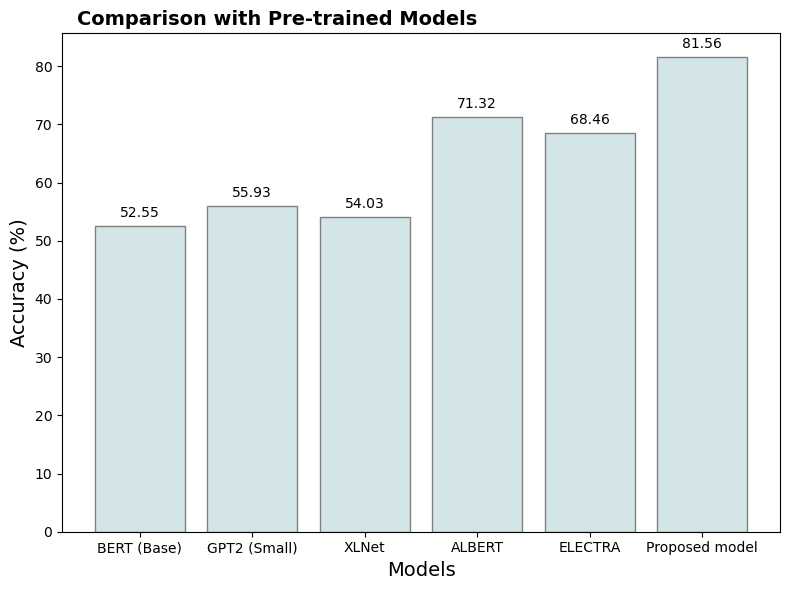

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    "Pre-trained Models": ["BERT (Base)", "GPT2 (Small)", "XLNet", "ALBERT", "ELECTRA","Proposed model"],
    "Accuracy (%)": [52.55, 55.93, 54.03, 71.32, 68.46, 81.56]
}

df = pd.DataFrame(data)

colors = ['#dfe5da', '#d3e5e6']

plt.figure(figsize=(8, 6))
barplot = plt.bar(df["Pre-trained Models"], df["Accuracy (%)"], color='#d3e5e6', edgecolor='grey')

for bar in barplot:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, round(yval, 2), ha='center', va='bottom')

plt.title('Comparison with Pre-trained Models', fontsize=14, fontweight='bold', position=(0.3, 1.0+0.05))
plt.xlabel('Models', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.tight_layout()
plt.show()